## KC Metro Data Exploration

Bootstrap the CSVs into dataframes.

In [244]:
## Get a dataframe going.

import os
import pandas as pd

# REF: https://pandas.pydata.org/pandas-docs/stable/user_guide/copy_on_write.html#copy-on-write-optimizations
# Used based on warning when attempting to update a subset of a dataframe downstream.
pd.set_option('mode.copy_on_write', True)
pd.options.mode.copy_on_write = True

AGENCY_DIR = 'kc_metro'

data = {
    "routes": {
        "csv": "routes.txt",
        "df": None
    },
    "stops": {
        "csv": "stops.txt",
        "df": None
    },
    "stop_times": {
        "csv": "stop_times.txt",
        "df": None
    },
    "trips": {
        "csv": "trips.txt",
        "df": None
    },
}

for header, vals in data.items():
    data_dir = os.path.join(os.getcwd(), os.pardir, os.pardir, 'data')
    data_csv =  os.path.join(data_dir, AGENCY_DIR, vals['csv'])
    data_df = pd.read_csv(data_csv)
    data[header]['df'] = data_df


#### Try to find all stops for a given route (from `routes.txt`)

In [245]:
ROUTE_ID = 100275

# Get some sample `trip_id` values for Route 8
# From `trips.txt`
trips_df = data['trips']['df']
trips_filtered_by_route = trips_df[trips_df['route_id'] == ROUTE_ID]['trip_id']
trips_filtered_by_route.head()


12523    572987776
12524    572987826
12525    572987836
12526    572987856
12527    572987866
Name: trip_id, dtype: int64

In [246]:
FIRST_TRIP_ID = trips_filtered_by_route.head(1).values[0]

# Filter `stop_times.txt` to get stop ids
stop_times_df = data['stop_times']['df']
stop_ids = stop_times_df[stop_times_df['trip_id'] == FIRST_TRIP_ID]['stop_id']

# Total number of stop counts
stop_ids.count()

np.int64(35)

In [247]:
# Join previously filtered stop_ids to stops.txt
# giving us the stop geometries

stops_df = data['stops']['df']

stops_filtered_by_route = pd.merge(stop_ids, stops_df)

stops_filtered_by_route.head()

,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,stop_timezone,wheelchair_boarding
0,8402,8402,Mount Baker Transit Center - Bay 2,NaN,47.577591,-122.297127,1,NaN,0,NaN,America/Los_Angeles,1
1,8672,8672,Martin L King Jr Way S & S Bayview St,NaN,47.581486,-122.297020,1,NaN,0,NaN,America/Los_Angeles,1
2,36752,36752,Martin L King Jr Way S & S Walker St,NaN,47.583851,-122.298042,1,NaN,0,NaN,America/Los_Angeles,1
3,12497,12497,Martin L King Jr Way S & S Massachusetts St,NaN,47.588676,-122.297852,1,NaN,0,NaN,America/Los_Angeles,1
4,43765,43765,Martin L King Jr Way S & S Irving St,NaN,47.590630,-122.297348,1,NaN,0,NaN,America/Los_Angeles,1


In [248]:
## Make a map

import folium

m = folium.Map(location=[47.617, -122.34], zoom_start=15)

## `Polyline()` Expects a list of coordinate tuples.
coord_data = list(zip(stops_filtered_by_route['stop_lat'], stops_filtered_by_route['stop_lon']))

## Get the route name

route_df = data['routes']['df']
route_num = route_df[route_df['route_id'] == ROUTE_ID]['route_short_name'].values[0]
route_name = route_df[route_df['route_id'] == ROUTE_ID]['route_desc'].values[0]
route_name_pretty = " | ".join([route_num, route_name])

folium.PolyLine(coord_data, tooltip=route_name_pretty).add_to(m)

## Display the map
m

## Try to generate a visualization showing the frequency of trips by hour for a given route

In [249]:
## filter stop_times.txt by trip_id where stop_sequence is 1
trips_and_stop_times = pd.merge(trips_filtered_by_route, stop_times_df, on='trip_id')
trips_first_stop_only = trips_and_stop_times[trips_and_stop_times['stop_sequence'] == 1]

## Note: `arrival_time` represents midnight values as 24:00:00 versus 00:00:00.
trips_first_stop_only['arrival_time'].sort_values()





2979     05:00:00
15692    05:01:00
21835    05:30:00
4455     05:30:00
5300     05:30:00
           ...   
10370    24:30:00
15657    24:30:00
2697     24:30:00
23923    24:31:00
21409    24:31:00
Name: arrival_time, Length: 742, dtype: object

In [250]:
## Convert arrival time hour values of `24` to `00`

trips_first_stop_only['arrival_time'] = trips_first_stop_only['arrival_time'].str.replace('^24', '00', regex=True)
trips_first_stop_only['arrival_time'].sort_values()

## Update `arrival_time` to be a datetime object
trips_first_stop_only['arrival_time'] = pd.to_datetime(trips_first_stop_only['arrival_time'], format='%H:%M:%S')

In [251]:
## Get the number of trips by hour
trips_per_hour = trips_first_stop_only.groupby(trips_first_stop_only['arrival_time'].dt.hour).size()

Matplotlib is building the font cache; this may take a moment.


<Axes: xlabel='arrival_time'>

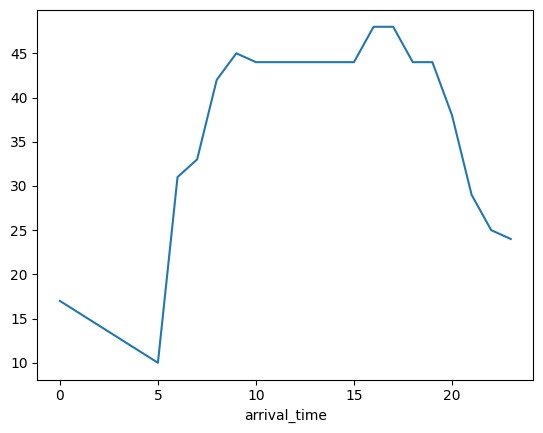

In [252]:
import matplotlib.pyplot as plt

trips_per_hour.plot(kind='bar')